In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
np.random.seed(11)

> raw data

In [3]:
raw_data = pd.read_csv('raw.csv').set_index("Date")

In [4]:
first_two_years = raw_data[:730]
first_two_years.tail()

,Value
Date,
1982-12-27,15.3
1982-12-28,16.3
1982-12-29,15.8
1982-12-30,17.7
1982-12-31,16.3


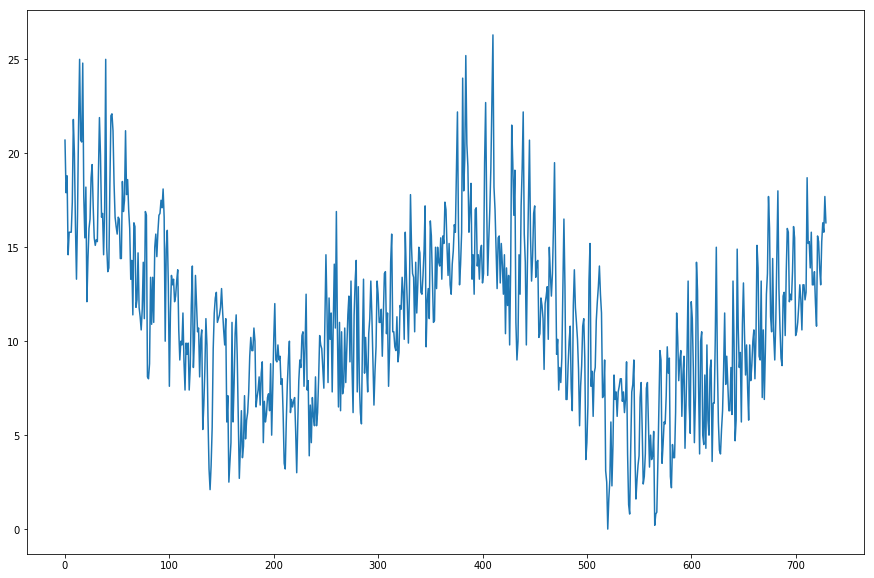

In [5]:
plt.figure(figsize = (15, 10))
plt.plot(list(range(730)), first_two_years.Value)
plt.show()

In [6]:
min(raw_data.Value), max(raw_data.Value)

(0.0, 26.3)

> training data & validation data

In [7]:
# 10 years data
data = pd.read_csv('train.csv')
data = data.set_index("Date")

In [8]:
# 9 years data for training
train_data = data[: -365]
train_X = train_data.iloc[:, :6].as_matrix()
train_Y = train_data.iloc[:, 6:].as_matrix()
train_X.shape, train_Y.shape

((2914, 6), (2914, 1))

In [9]:
# 1 year data for validation
validation_data = data[-365:]
valid_X = validation_data.iloc[:, :6].as_matrix()
valid_Y = validation_data.iloc[:, 6:].as_matrix()
valid_X.shape, valid_Y.shape

((365, 6), (365, 1))

> test data

In [10]:
test_data = pd.read_csv('test.csv')
test_data = test_data.set_index('Date')
test_data = test_data.as_matrix()
test_data.shape

(52, 6)

> model

In [11]:
timesteps = 6
data_dim = 1
output_dim = 1
learning_rate = 0.001
training_epoch = 1000

In [12]:
X = tf.placeholder(tf.float32, [None, timesteps, data_dim])
Y = tf.placeholder(tf.float32, [None, output_dim])

> multi cells with different num_units

In [13]:
cells = []
for num in range(3):
    # num_units을 크게 주면 epoch이 400을 넘어가며 널뛰기하는 현상보임. 128이하가 적당한 것을 발견
    cell = tf.contrib.rnn.BasicLSTMCell(num_units = 256, state_is_tuple = True)
    #cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob = 0.7)
    cells.append(cell)

In [14]:
cell = tf.contrib.rnn.MultiRNNCell(cells)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)

In [15]:
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn = None)
loss = tf.reduce_mean(tf.square(Y_pred - Y))

> learning_rate = 0.005

In [16]:
learning_rate = 0.005
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

In [17]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [18]:
reshaped_train_X = train_X.reshape((*train_X.shape, 1))

for epoch in range(400):
    _, l = sess.run([train, loss], feed_dict = {X: reshaped_train_X, Y: train_Y})
    if epoch % 50 == 0:
        print(epoch,'RMSE = ', np.sqrt(l))

validPrediction = sess.run(Y_pred, feed_dict = {X: valid_X.reshape((*valid_X.shape, 1))})
#sess.close()

0 RMSE =  11.8312
50 RMSE =  4.05328
100 RMSE =  4.05259
150 RMSE =  3.8542
200 RMSE =  2.83409
250 RMSE =  2.55774
300 RMSE =  2.49296
350 RMSE =  2.5236


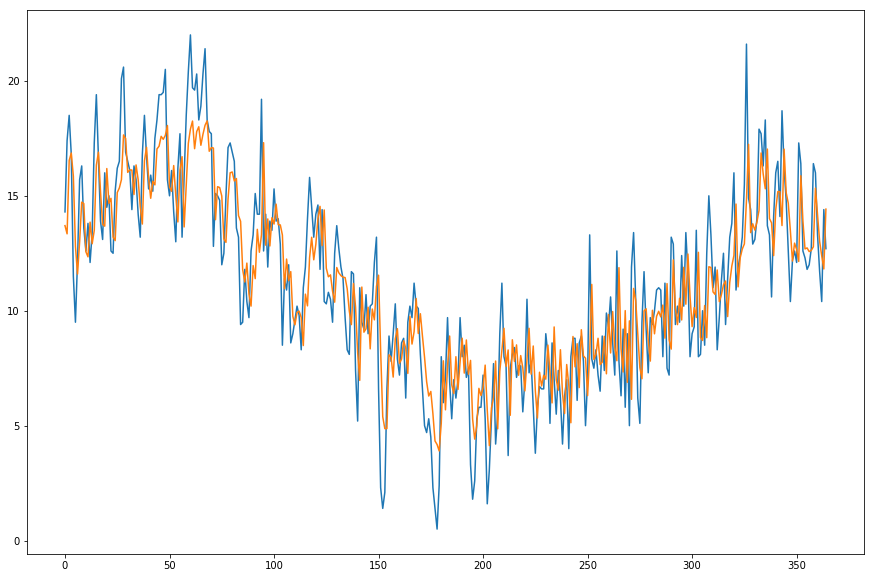

In [19]:
plt.figure(figsize = (15, 10))
plt.plot(valid_Y)
plt.plot(validPrediction)
plt.show()

In [21]:
# Test step
test_data = pd.read_csv('test.csv')
test_data = test_data.set_index("Date")
test_X = test_data.iloc[:, :6].as_matrix()
reshaped_test_X = test_X.reshape((*test_X.shape, 1))

test_predict = sess.run(Y_pred, feed_dict={X: reshaped_test_X})
result = [i for i in test_predict]

In [23]:
type(result[1])

numpy.ndarray